# Lecture 4 - Exercise

## Code Header

- **Group ID**: 742
- **Members**: 
	- Lukas Bisgaard Kristensen
	- Mads Østergaard Dinesen
	- Máté Tallósi
	- Tudor-Razvan Tatar
- **Date**: 26/09/2022
- **Lecture**: 4 - “Dimensionality reduction” 
- **Dependencies**: Jupyter Notebook, numpy=1.21.5, matplotlib=3.5.2, scipy=1.7.3, seaborn=0.11.2, pandas=1.4.3, scikit-learn=1.1.1
- **Python version**: 3.9+
- **Functionality**: We read in all of the training data and reduced the dimensionality to 2 with Principal Components Analysis for all of the 10 classes and the selected 3 as well. We created a PDFClassifier to evaluate the model accuracy and we tried to use a KNeighborsClassifier to evaluate the model as well.

*For insparation we used [this artical](https://medium.com/analytics-vidhya/principal-component-analysis-pca-with-code-on-mnist-dataset-da7de0d07c22), from medium.com*

## Reduce the dimensionality of the given database to 2 dimenson

### Read the traing data

In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import glob
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix

In [2]:
train_filenames = glob.glob('../Data/train*.txt')
train_filenames.sort()

train_datas = [np.loadtxt(filename) for filename in train_filenames]
train_labels = [[i] * len(train_datas[i]) for i in range(len(train_datas))]

In [3]:
train_data = np.concatenate(train_datas)
train_label = np.concatenate(train_labels)

print(f'Train data shape: {train_data.shape}')
print(f'Train label shape: {train_label.shape}')

Train data shape: (60000, 784)
Train label shape: (60000,)


### Plot a sample image

Mean: 32.537, Standard Deviation: 73.837


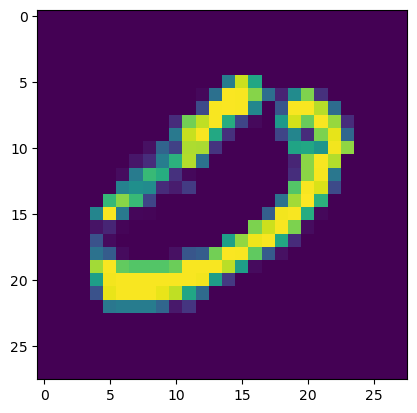

In [4]:
image = train_data[3421].reshape(28, 28)

print(f'Mean: {image.mean():.3f}, Standard Deviation: {image.std():.3f}')
plt.imshow(image)

## Principal Components Analysis on 10 classes

### Calculate the eigenvalues and select the two biggest one

In [5]:
covariance_train = np.cov(train_data, rowvar=False)
mean_train = np.mean(train_data, axis=0)
std_train = np.std(train_data, axis=0)

print(f'Covariance shape: {covariance_train.shape}')

v, w = sp.linalg.eigh(covariance_train, eigvals=[782, 783])

Covariance shape: (784, 784)


### Project the traing data from original space into the reduce one

In [6]:
z = w.T @ (train_data - mean_train).T
z.shape

(2, 60000)

In [7]:
new_coordinates = np.vstack((z, train_label)).T

train_df = pd.DataFrame(data=new_coordinates, columns=('1st_principal', '2nd_principal', 'label'))
train_df.head()

,1st_principal,2nd_principal,label
0,-294.857038,1011.718376,0.0
1,-354.929836,1037.651344,0.0
2,-239.789614,610.292593,0.0
3,-243.309856,933.879560,0.0
4,-90.813382,1663.961376,0.0


### Plot the result

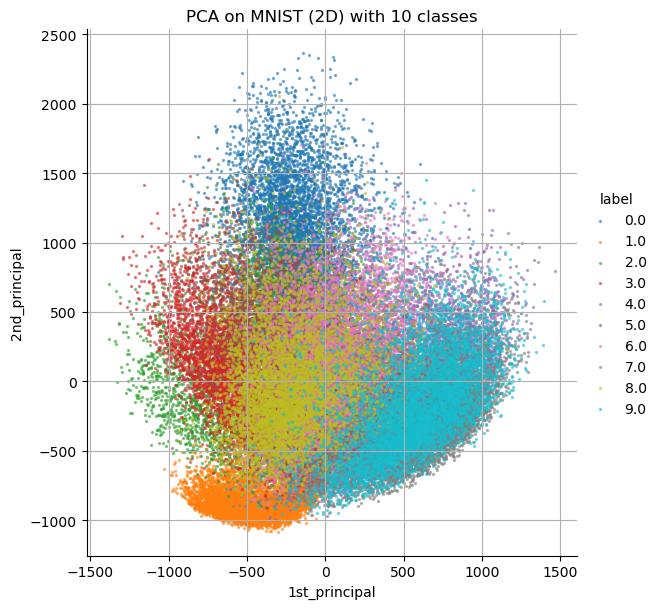

In [8]:
sns.FacetGrid(train_df, hue='label', height=6).map(plt.scatter, '1st_principal', '2nd_principal', s=2, alpha=0.5).add_legend()
plt.title('PCA on MNIST (2D) with 10 classes')
plt.grid()
plt.show()

## Principal Components Analysis on the 3 selected classes [5, 6, 8]

In [9]:
SELECTED_CLASSES = [5, 6, 8]

selected_train_data = train_data[np.isin(train_label, SELECTED_CLASSES)]
selected_train_label = train_label[np.isin(train_label, SELECTED_CLASSES)]

### Calculate the eigenvalues and select the two biggest one

In [10]:
selected_covariance_train = np.cov(selected_train_data, rowvar=False)
selected_mean_train = np.mean(selected_train_data, axis=0)
selected_std_train = np.std(selected_train_data, axis=0)

print(f'Covariance shape: {selected_covariance_train.shape}')

selected_v, selected_w = sp.linalg.eigh(selected_covariance_train, eigvals=[782, 783])

Covariance shape: (784, 784)


### Project the traing data from original space into the reduce one

In [11]:
selected_z = selected_w.T @ (selected_train_data - selected_mean_train).T
selected_z.shape

(2, 17190)

In [12]:
new_coordinates = np.vstack((selected_z, selected_train_label)).T

selected_train_df = pd.DataFrame(data=new_coordinates, columns=('1st_principal', '2nd_principal', 'label'))
selected_train_df.head()

,1st_principal,2nd_principal,label
0,18.825192,-383.501647,5.0
1,649.597283,-122.315768,5.0
2,692.391485,-348.289435,5.0
3,656.561940,-652.952631,5.0
4,642.847791,-224.849800,5.0


### Plot the results

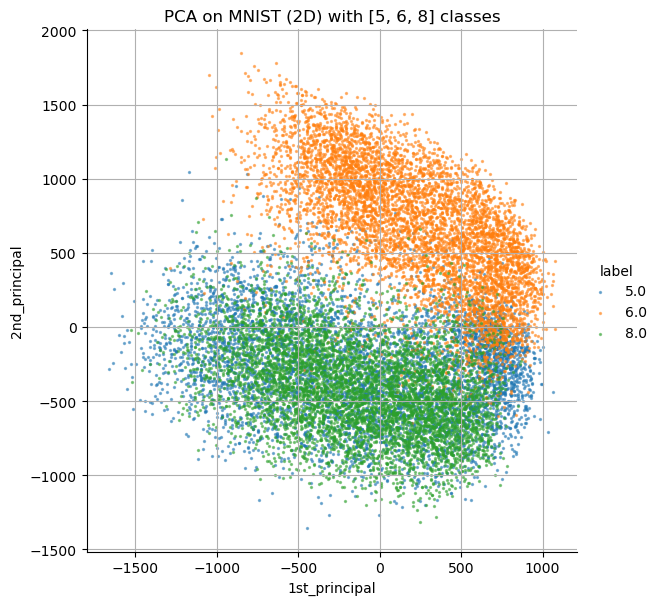

In [13]:
sns.FacetGrid(selected_train_df, hue="label", height=6).map(plt.scatter, '1st_principal', '2nd_principal', s=2, alpha=0.5).add_legend()
plt.title(f'PCA on MNIST (2D) with {SELECTED_CLASSES} classes')
plt.grid()
plt.show()

## Perform 3-class classification based on the generated 2D data

### Creating Probability Density Function (PDF) classifier

In [14]:
class PDFClassifier:
    def __init__(self, priors={}, pdfs={}, classes=[]):
        self.priors = priors
        self.pdfs = pdfs
        self.classes = classes
    
    def fit(self, X, y):
        if (X.shape[0] != y.shape[0]):
            raise ValueError('X and y must have the same number of samples')
        
        self.classes = np.unique(y)
        
        for c in self.classes:
            X_c = X[y == c]
            self.priors[c] = X_c.shape[0] / X.shape[0]
            self.pdfs[c] = sp.stats.multivariate_normal(mean=np.mean(X_c, axis=0), cov=np.cov(X_c.T))
    
    def predict(self, X):
        y_pred = np.zeros(X.shape[0])
        
        for i, x in enumerate(X):
            probs = [self.pdfs[c].pdf(x) * self.priors[c] for c in self.classes]
            y_pred[i] = self.classes[np.argmax(probs)]
        
        return y_pred
    
    def score(self, X, y):
        if (X.shape[0] != y.shape[0]):
            raise ValueError('X and y must have the same number of samples')
        
        y_pred = self.predict(X)
        return np.sum(y_pred == y) / y.shape[0]

### Read the testing data

In [15]:
test_filenames = glob.glob('../Data/test*.txt')
test_filenames.sort()

test_datas = [np.loadtxt(filename) for filename in test_filenames]
test_labels = [[i] * len(test_datas[i]) for i in range(len(test_datas))]

In [16]:
test_data = np.concatenate(test_datas)
test_label = np.concatenate(test_labels)

print(f'Test data shape: {test_data.shape}')
print(f'Test label shape: {test_label.shape}')

Test data shape: (10000, 784)
Test label shape: (10000,)


### Project the testing data from original space into the reduce one

In [17]:
test_z = w.T @ (test_data - mean_train).T
test_z.shape

(2, 10000)

In [18]:
new_coordinates = np.vstack((test_z, test_label)).T

test_df = pd.DataFrame(data=new_coordinates, columns=('1st_principal', '2nd_principal', 'label'))
test_df.head()

,1st_principal,2nd_principal,label
0,112.940451,1233.906987,0.0
1,-611.163841,1125.543743,0.0
2,33.000084,1049.327073,0.0
3,-108.279067,1888.904242,0.0
4,-354.995358,1128.037980,0.0


### Select the given classes from the test dataset

In [19]:
selected_test_df = test_df[np.isin(test_df['label'], SELECTED_CLASSES)]

In [20]:
X_train = selected_train_df[['1st_principal', '2nd_principal']].values
Y_train = selected_train_df['label'].values

X_test = selected_test_df[['1st_principal', '2nd_principal']].values
Y_test = selected_test_df['label'].values

### Create confusion matrix plotter

In [21]:
def plot_confusion_matrix(cf_matrix, classes, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    Plots a confusion matrix for a given set of classes
    """
    ax = plt.subplot()
    
    sns.heatmap(cf_matrix, annot=True, fmt='d', cmap=cmap, ax=ax)
    
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')
    ax.xaxis.set_ticklabels(classes)
    ax.yaxis.set_ticklabels(classes)
    
    plt.title(title)
    
    plt.show()

### Evaluate the PDFClassifier on the given selected test dataset

In [22]:
model = PDFClassifier()

model.fit(X_train, Y_train)

Y_pred = model.predict(X_test)
accuracy = model.score(X_test, Y_test)

print(f'Accuracy: {accuracy:.4f}')

Accuracy: 0.4600


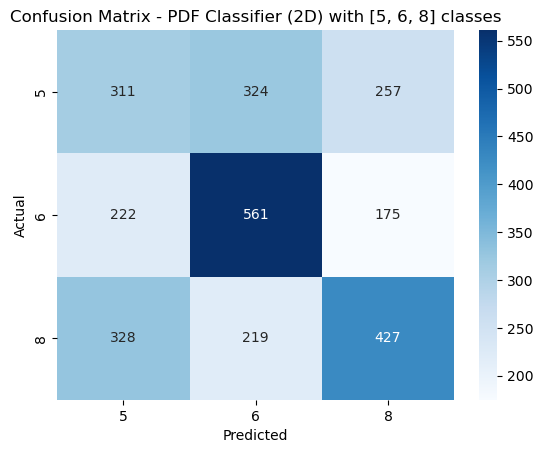

In [23]:
cf_matrix = confusion_matrix(Y_test, Y_pred, labels=SELECTED_CLASSES)

plot_confusion_matrix(cf_matrix, SELECTED_CLASSES, title=f'Confusion Matrix - PDF Classifier (2D) with {SELECTED_CLASSES} classes')

### Evaluate the KNeighborsClassifier on the given selected test dataset

In [24]:
model = KNeighborsClassifier(n_neighbors=100)

model.fit(X_train, Y_train)

Y_pred = model.predict(X_test)
accuracy = model.score(X_test, Y_test)

print(f'Accuracy: {accuracy:.4f}')

Accuracy: 0.4635


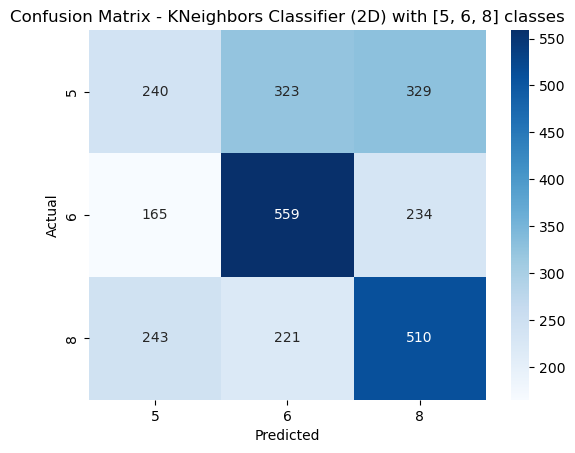

In [25]:
cf_matrix = confusion_matrix(Y_test, Y_pred, labels=SELECTED_CLASSES)

plot_confusion_matrix(cf_matrix, SELECTED_CLASSES, title=f'Confusion Matrix - KNeighbors Classifier (2D) with {SELECTED_CLASSES} classes')